```{eval-rst}
.. include:: sinebow.rst

```
{sinebow26}`Gamma`
==================

One of the more trivial uses of good binary segmentation (let alone best-in-class *instance* segmentation) is the ability to adjust an image based on foreground/background values. 

{header-2}`Example Image`
--------------------------
To start off, consider this example image:

In [ ]:
%load_ext autoreload
%autoreload 2

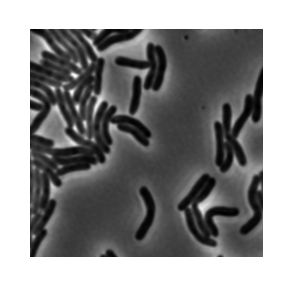

In [ ]:
%%capture --no-display 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background') 
dpi = 600
mpl.rcParams['figure.dpi'] = dpi
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

%matplotlib inline

import numpy as np
import omnipose
from omnipose.plot import imshow
from pathlib import Path
import os
from cellpose_omni import io, plot
omnidir = Path(omnipose.__file__).parent.parent.parent
basedir = os.path.join(omnidir,'docs','test_files') 
im = io.imread(os.path.join(basedir,'e1t1_crop.tif'))

imshow(im,1,cmap='gray')

This image is 16-bit and already adjusted to span the entire bit depth:

In [ ]:
print(im.dtype, im.ptp()==(2**16-1))

uint16 True


{header-2}`Exposure and outliers`
----------------------------------

Raw data is often under- or over-exposed and can contain outliers where pixels are saturated. We can simulate this by dividing the image by 2 and adding a bright pixel:

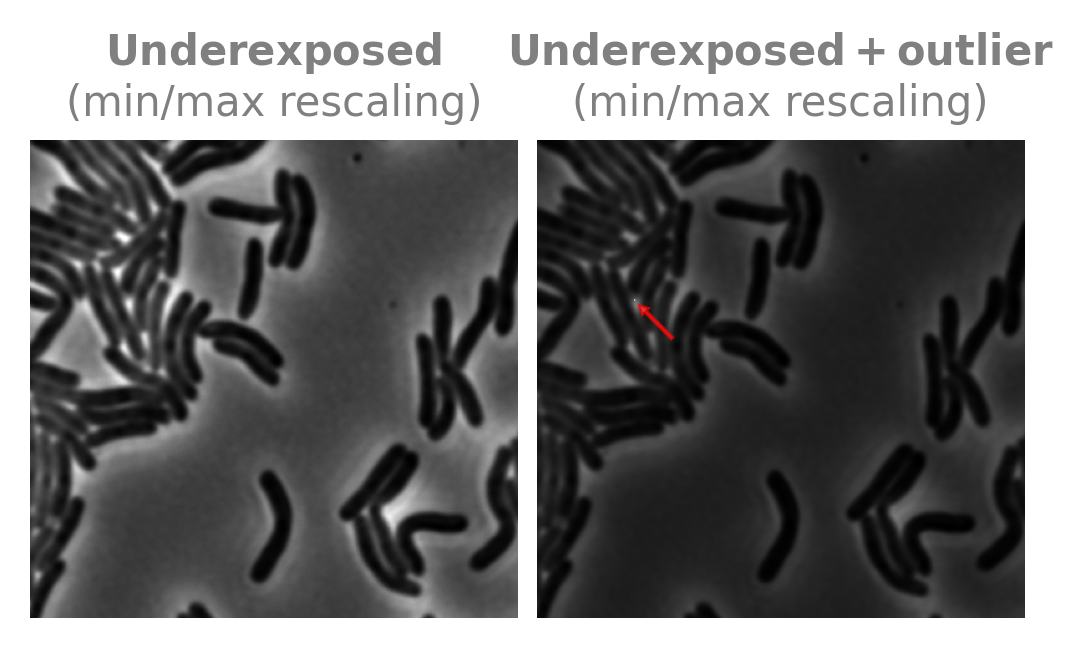

In [ ]:
im_bad = im * .5 # reduce brightness by 50%

f = 1
c = [0.5]*3
fontsize=10

# Number of subplots in the right column
n = 2
h, w = im_bad.shape[:2]

sf = w
p = 0.0001*w # needs to be defined as fraction of width for aspect ratio to work? 
h /= sf
w /= sf

# Calculate positions of subplots
left = np.array([i*(w+p) for i in range(n)])*1.
bottom = np.array([0]*n)*1.
width = np.array([w]*n)*1.
height = np.array([h]*n)*1.

max_w = left[-1]+width[-1]
max_h = bottom[-1]+height[-1]

sf = max_w - (n-1)*p
left /= sf
bottom /= sf
width /= sf
height /= sf


s = 6.5 * 2/4 # make it so that these appear the same size 
fig = plt.figure(figsize=(s,s), frameon=False, dpi=300)

ax = fig.add_axes([left[0], bottom[0], width[0], height[0]])
ax.imshow(im_bad,cmap='gray')
ax.axis('off')
ax.set_title(r'$\bf{Underexposed}$' + '\n(min/max rescaling)',c=c,fontsize=fontsize)

y,x = im.shape[0]//3,im.shape[1]//5
im_bad[y,x] = im_bad.max()*2 # add a bright pixel 
im_bad = omnipose.utils.rescale(im_bad)

ax = fig.add_axes([left[1], bottom[1], width[1], height[1]])
ax.imshow(im_bad,cmap='gray')
ax.axis('off')
ax.set_title(r'$\bf{Underexposed+outlier}$' + '\n(min/max rescaling)',c=c,fontsize=fontsize)

scale = 50
arrow_length = 0.1*scale
dx=dy=-5
offx=offy=-5
ax.arrow(x - dx*arrow_length-offx, y - dy*arrow_length-offy, dx*arrow_length, dy*arrow_length,
         width=0.01*scale, head_width=0.1*scale, head_length=0.1*scale,  
            fc=None, ec=[1.,0,0,0.75],
            clip_on=False,
            length_includes_head=True)

fig.subplots_adjust(wspace=0.1)

In [ ]:
datadir = omnidir.parent
fig.savefig(os.path.join(datadir,'Dissertation','figures','outlier.pdf'),
    transparent=True,bbox_inches='tight',pad_inches=0)

The `plt.imshow` command simply maps the minimum value of the image to 0 and the maximum value of the image to 1, i.e. it applies standard *0-1 min-max normalization*. This explains the dark appearance once we add in a bright pixel, as most of the image gets mapped to the bottom half of the available color map.

This is annoying when visualizing images next to each other, but it is particularly problematic when we need to standardize the images we feed into a neural network. We can choose to make all images 0-1, 0-255, etc. (and these can go above or below the minimum and maximum by a little), but it is much harder for a network to learn foreground from background if the images are chaotically rescaled like the above example (chaotic meaning that the image darkening is highly sensitive to the particular condition of whether or not there are saturated pixels). 

We solve this by normalizing the image not by the absolute min and max, but by percentiles. We set pixels at or below the 0.01 percentile to 0 and those at or above the 99.99th percentile to 1. (Cellpose uses 1 and 99, but this will mess up images with very few cells compared to background). 


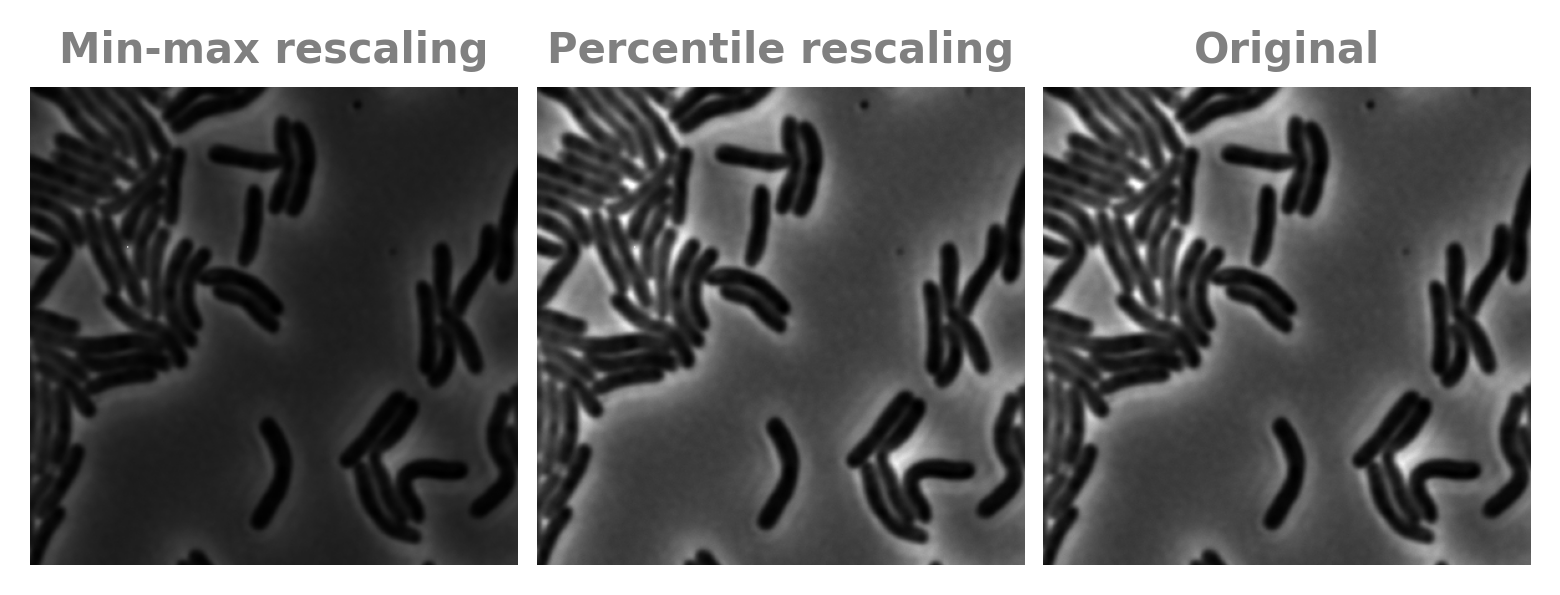

In [ ]:
from omnipose.utils import normalize99

im_fixed = normalize99(im_bad)
# print('normalize99() fixes the image:')
# imshow(np.hstack((im_bad,im_fixed)),2,cmap='gray')

f = 1
c = [0.5]*3
fontsize=10

titles = ['Min-max rescaling','Percentile rescaling','Original']
ims = [im_bad,im_fixed,im]

# Number of subplots in the right column
n = len(ims)
h, w = ims[0].shape[:2]

sf = w
p = 0.0001*w # needs to be defined as fraction of width for aspect ratio to work? 
h /= sf
w /= sf

# Calculate positions of subplots
left = np.array([i*(w+p) for i in range(n)])*1.
bottom = np.array([0]*n)*1.
width = np.array([w]*n)*1.
height = np.array([h]*n)*1.

max_w = left[-1]+width[-1]
max_h = bottom[-1]+height[-1]

sf = max_w - (n-1)*p
left /= sf
bottom /= sf
width /= sf
height /= sf


s = 6.5 * 3/4 # make it so that these appear the same size 
fig = plt.figure(figsize=(s,s), frameon=False, dpi=300)


for i in range(n):
    ax = fig.add_axes([left[i], bottom[i], width[i], height[i]])
    ax.imshow(ims[i],cmap='gray')
    ax.axis('off')
    ax.set_title(titles[i],c=c,fontsize=fontsize,fontweight="bold")



In [ ]:
datadir = omnidir.parent
file = os.path.join(datadir,'Dissertation','figures','percentile.pdf')
if os.path.isfile(file): os.remove(file)
fig.savefig(file,transparent=True,bbox_inches='tight',pad_inches=0)

With an image that has been properly normalized from 0 to 1, we can further adjust it. Right now we cannot see a lot of detail in the dark parts of the image; what we can do is raise the image to some power, called **gammma adjustment**. Because $0^x = 0$ and $1^x = 1$, we can make the image globally brighter or darker without affecting the total range:


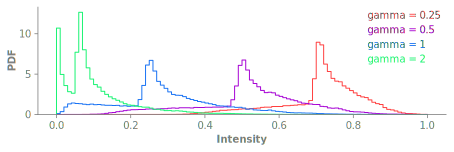

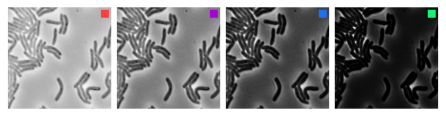

In [ ]:
# %matplotlib inline
from omnipose.utils import sinebow

im_gamma = []
gamma = [0.25, 0.5, 1, 2]
N = len(gamma)
    
dpi = 300
mpl.rcParams['figure.dpi'] = dpi
mpl.rcParams["axes.facecolor"] = [0,0,0,0]
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
axcol = [0.5]*3
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

w=6
labelsize = 10
# fig1,ax = plt.subplots(figsize=(w,w/N),facecolor='#0000',frameon=False,)
fig1 = plt.figure(figsize=(w,w/N), 
                  # frameon=False, 
                  facecolor='#0000',
                  # tight_layout={'pad':10}
                 )
offset = 0.05
ax = fig1.add_axes([offset,0,1-offset,1])
fig1.subplots_adjust(left=offset, bottom=0, right=1, top=1, wspace=0, hspace=0)

color = sinebow(N+1)
for j,g in enumerate(gamma):
    i = im_fixed**g
    im_gamma.append(i)
    ax.hist(i.flatten(),
             bins=100,
             label='gamma = {}'.format(g),
             color=color[j+1],
             histtype='step',
             density=True)

l = ax.legend(prop={'size': labelsize},
               frameon=False,
               bbox_to_anchor=(1, 1),
               loc='upper right', 
               borderaxespad=0.)
for text,c in zip(l.get_texts(),[color[i] for i in range(1,N+1)]):
    text.set_color(c)
    
for item in l.legend_handles:
    item.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.patch.set_alpha(0.0)
plt.xlabel('Intensity',size=labelsize,c=axcol,fontweight='bold')
plt.ylabel('PDF',size=labelsize,c=axcol,fontweight='bold')

ax.yaxis.set_label_coords(-offset,0.5)


ax.tick_params(axis='both', colors=axcol)
ax.spines['bottom'].set_color(axcol)
ax.spines['left'].set_color(axcol)

plt.show()


# %matplotlib inline
%config InlineBackend.figure_formats = ['png']
# mpl.use('Agg')

h,w = im.shape[-2:]

# Number of subplots in the right column
n = len(im_gamma)

sf = w
p = 0.05
h /= sf
w /= sf

# Calculate positions of subplots
left = np.array([i*(w+p) for i in range(n)])*1.
bottom = np.array([0]*n)*1.
width = np.array([w]*n)*1.
height = np.array([h]*n)*1.

max_w = left[-1]+width[-1]
max_h = bottom[-1]+height[-1]

sw = max_w
sh = max_h

sf = max(sw,sh)
left /= sw
bottom /= sh
width /= sw
height /= sh

# Create figure
s = 6
fig2 = plt.figure(figsize=(s,s*sh/sw), frameon=False, dpi=600)#,tight_layout={'pad':0})
# fig2.patch.set_facecolor([0]*4)

# Add subplots
axes = []
for i in range(n):
    ax = fig2.add_axes([left[i], bottom[i], width[i], height[i]])
    axes.append(ax)


# fig2, axes = plt.subplots(1,4, figsize=(w,w/4))  
# fig2.patch.set_facecolor([0]*4)

sz = im.shape
pad = 10
width = 30
slc = (slice(pad,pad+width),slice(sz[1]-(pad+width),sz[1]-pad),Ellipsis)

for i,(ax,ig) in enumerate(zip(axes,im_gamma)):
    ax.axis('off')
    ig = np.stack([ig]*3+[np.ones_like(ig)],axis=-1)
    ig[slc] = color[i+1]
    ax.imshow(ig)

fig2.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# plt.show()

In [ ]:
datadir = omnidir.parent
# fig1.savefig(os.path.join(datadir,'Dissertation','figures','gammahist.pdf'),
#     transparent=True,bbox_inches='tight',pad_inches=0)

file = os.path.join(datadir,'Dissertation','figures','gammahist.pdf')
if os.path.isfile(file): os.remove(file)
fig1.savefig(file,transparent=True,bbox_inches='tight',pad_inches=0)

file = os.path.join(datadir,'Dissertation','figures','gammapics.png')
if os.path.isfile(file): os.remove(file)
fig2.savefig(file,transparent=True,pad_inches=0,bbox_inches='tight')

Note that fractional powers only work (without going into complex numbers) if the image values are nonnegative. 


{header-2}`Semantic gamma normalization`
-----------------------------------------
We can next use image segmentation in combination with gamma adjustment to normalize image brightness. This is very handy for making figures with images coming from different microscopes or optical configurations. To demonstrate, let's load in the image set from our *mono_channel_bact* notebook and the corresponding masks we made with Omnipose.

In [ ]:
from pathlib import Path
import os
from cellpose_omni import io, transforms

mask_filter='_cp_masks'
img_names = io.get_image_files(basedir,mask_filter,look_one_level_down=True)
mask_names = io.get_label_files(img_names,subfolder='masks')
imgs =  [io.imread(i) for i in img_names]
imgs = [im if im.ndim==2 else im[...,0] for im in imgs]
masks = [io.imread(m) for m in mask_names]

Now we will compare standard normalization to what I am calling "semantic gamma normalization". My implementation of it can be found in `omnipose.utils`, which simply answers the question: "what is the power to which I need to raise my image such that the average background becomes equal to a given value?". From left to right, I plot `im/max(im.dtype)` (so min>=0 and max=1), 0-1 remapping of `im` (`recsale`), percentile remapping of `im` (`normalize99`), gamma normalization to background of 1/3, and gamma normalization of background to 1/2. The output has been set to use the same colormap and interpolation (`vmin` and `vmax` are otherwise set by the min and max of the image).

In [ ]:
from omnipose.utils import rescale, normalize_image

textcolor = [0.5]*3

f = 1
labelsize = 8*f
fontsize = 4*f
fontsize3 = 12*f
    
# Assume the images are stored in a nested list
images = []
for im, mask in zip(imgs,masks):
    
    # format the image
    im = transforms.move_min_dim(im) # move the channel dimension last
    if len(im.shape)>2:
        im = im[:,:,1] 
    
    im_raw = im/np.iinfo(im.dtype).max
    
    im_rescale = rescale(im)
    im_norm = normalize99(im)
    im_gamma_3 = normalize_image(im, mask>0, target=1/3)
    im_gamma_2 = normalize_image(im, mask>0, target=1/2)

    images.append([im_raw,im_rescale,im_norm,im_gamma_3, im_gamma_2])

images = images[::-1]
titles = ['raw','minmax','percentile','$\gamma=1/3$', '$\gamma=1/2$']

kwargs = {'cmap':'gray','vmin':0,'vmax':1}
numt = [str(i) for i in range(len(images))]
fig = omnipose.plot.image_grid(images,column_titles=titles,
                                 # row_titles=numt,
                                 figsize=6,
                                 outline=True,
                                 # order = 'ji',    
                                 **kwargs)

fig

In [ ]:
# fig.savefig(os.path.join(datadir,'Dissertation','figures','gammanorm.pdf'),
#     transparent=True,bbox_inches='tight',pad_inches=0)

# fig.savefig(os.path.join(datadir,'Dissertation','figures','gammanorm.png'),
#     transparent=True,bbox_inches='tight',pad_inches=0)

# datadir = omnidir.parent
file = os.path.join(datadir,'Dissertation','figures','gammanorm.pdf')
if os.path.isfile(file): os.remove(file)
fig.savefig(file,transparent=True,bbox_inches='tight')

The first column provides an essentially 'raw' view of the image, as it has not been shifted or stretched relative to the original max and min of its data type. As noted in the segmentation notebook, that first image is super dark because it is an 8-bit image (0-255), but only takes on values from 4 to 22. My code above divides by 255 for uint8 images and 65535 for uint16 images. 

The second and third columns do stretch the image to fill the whole 0-1 range, but you can see how the images still have different background intensity. My function in columns 4 and 5 normalize the background to a constant value. Well-exposed bacterial phase contrast images seem to have a 'natural' background value of about 1/3. 